# A First Attempt at Gradient Descent
## Introduction
To test my unsterstanding so far, this is my attemp to implement a basic multiple linear regression model using the techniques of gradient descent described in the Machine Learning Specialization course by Andrew Ng on Coursera: https://www.coursera.org/learn/machine-learning

I made an effort to write the main functions `compute_cost`, `compute_gradient`, and `gradient_descent`, on my own from my course notes. Otherwise, the code below is mostly based on or copied from the labs in that course, with modifications to suit the data set I selected.

Essentially at random, and because it bears a resemblance to the worked example in the course, I selected the Boston House Prices dataset to work with. I used a version of the dataset that a user on Kaggle had already cleaned up: https://www.kaggle.com/datasets/fedesoriano/the-boston-houseprice-data 

## Handling the Raw Data
I used Pandas to read the data into a format that was easier for me to work with:

In [26]:
import copy
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

housing_data = pd.read_csv('boston.csv', header=0)

The rows of the resulting dataframe look like this:
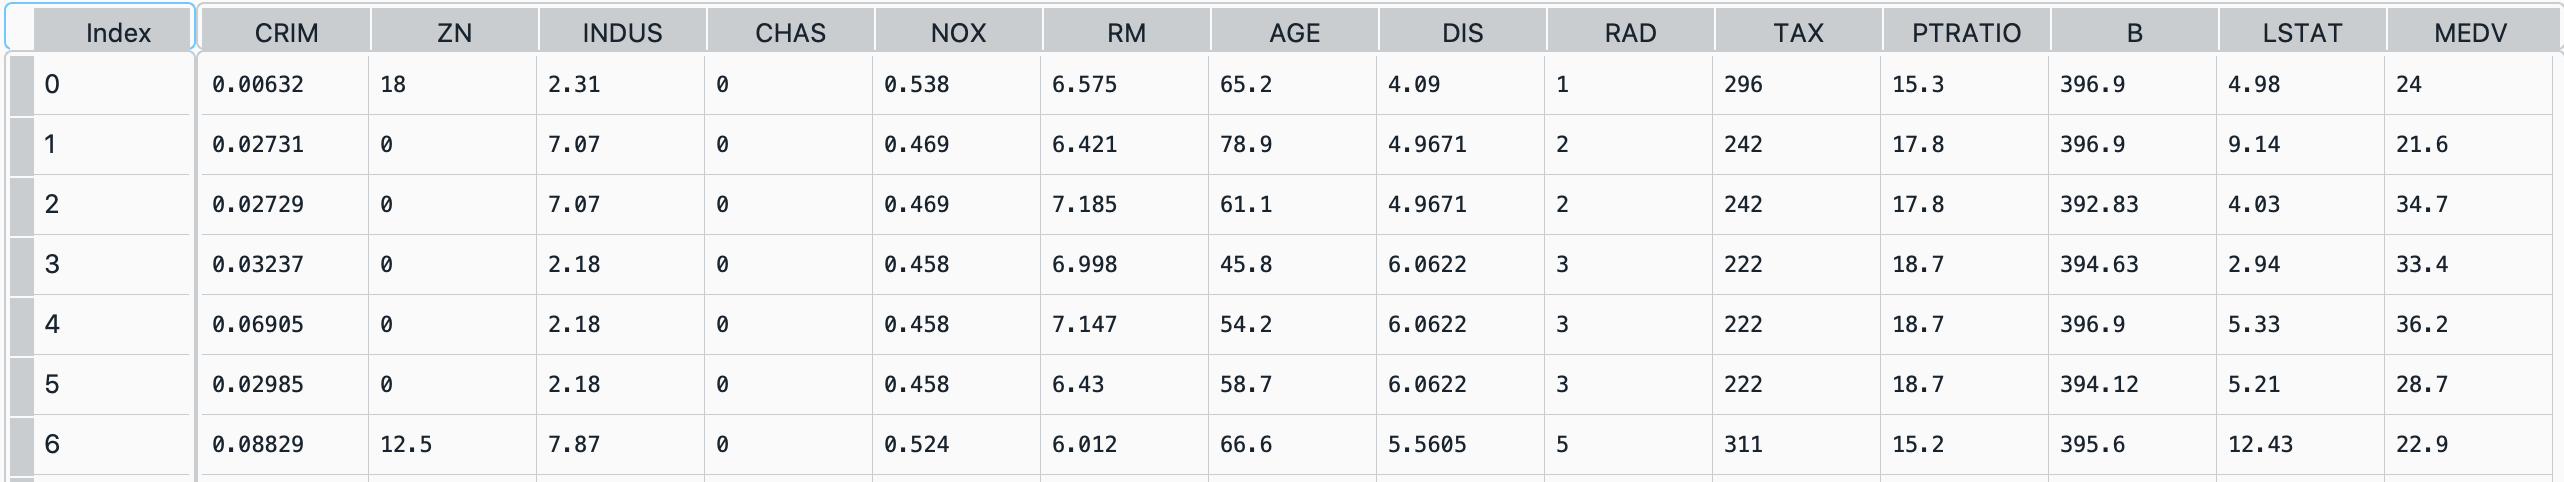

Then, I gathered the training inputs `X_train` and training outputs `y_train` into numpy arrays.

In [2]:
X_train = housing_data[['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX',
       'PTRATIO', 'B', 'LSTAT']].to_numpy()
y_train = housing_data['MEDV'].to_numpy()

For easy reference:
Input features in order:
- CRIM: per capita crime rate by town
- ZN: proportion of residential land zoned for lots over 25,000 sq.ft.
- INDUS: proportion of non-retail business acres per town
- CHAS: Charles River dummy variable (1 if tract bounds river; 0 otherwise)
- NOX: nitric oxides concentration (parts per 10 million)
- RM: average number of rooms per dwelling
- AGE: proportion of owner-occupied units built prior to 1940
- DIS: weighted distances to five Boston employment centres
- RAD: index of accessibility to radial highways
- TAX: full-value property-tax rate per $10,000
- PTRATIO: pupil-teacher ratio by town
- B: The result of the equation B=1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town
- LSTAT: lower status of the population

Output target variable:
- MEDV: Median value of owner-occupied homes in $1000's

## Visualizing the Raw Data
I'll start by plotting each input feature against the ouput (median home price):

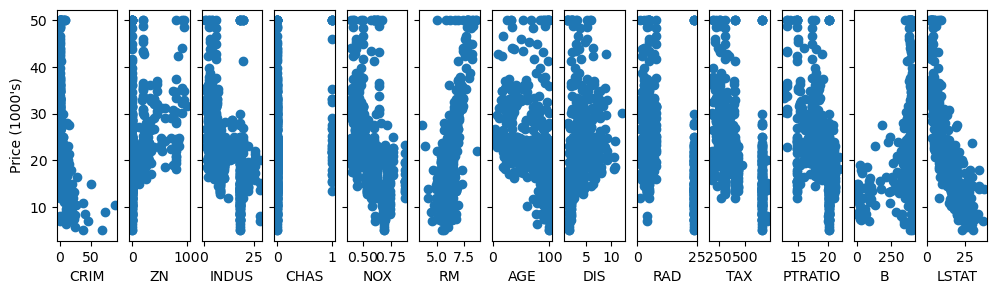

In [3]:
feature_names = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX',
       'PTRATIO', 'B', 'LSTAT']

fig,ax=plt.subplots(1, 13, figsize=(12, 3), sharey=True)
for i in range(len(ax)):
    ax[i].scatter(X_train[:,i],y_train)
    ax[i].set_xlabel(feature_names[i])
ax[0].set_ylabel("Price (1000's)")
plt.show()

Okay, so the plots are a bit ugly, but you get the idea. I'll fix that later.

Some variable look like they might be more influencial (e.g. crime, industry, nitric oxides, low status) while other seem less influential (Charles river, residential zoning) but for the sake of this exercise I'll just use everything.

## Normalizing the Data

The ranges for each feature are pretty varied. So, before I attempt a gradient descent, I'll normalize them using z-score normaliation.

In [27]:
mu     = np.mean(X_train,axis=0)   
sigma  = np.std(X_train,axis=0) 
X_mean = (X_train - mu)
X_norm = (X_train - mu)/sigma
print(f"Peak to Peak range by column in Raw Data:")
print(f"{np.ptp(X_train,axis=0)}")  
print(f"Peak to Peak range by column in Normalized Data:")
print(f"{np.ptp(X_norm,axis=0)}")

Peak to Peak range by column in Raw Data:
[8.896988e+01 1.000000e+02 2.728000e+01 1.000000e+00 4.860000e-01
 5.219000e+00 9.710000e+01 1.099690e+01 2.300000e+01 5.240000e+02
 9.400000e+00 3.965800e+02 3.624000e+01]
Peak to Peak range by column in Normalized Data:
[10.35371254  4.29195681  3.98040695  3.94099643  4.19822841  7.43529363
  3.45293153  5.22758688  2.64408811  3.11218423  4.34620743  4.34824524
  5.07989791]


As expected, we observe that the peak to peak ranges after normalization are all relatively close to one another.

## Implemeting Gradient Descent

### Goal
My goal is to build a linear model of the form
$$f_{\vec{w},b}(\vec{x})=\vec{w}\cdot\vec{x}+b$$

### Strategy
The strategy will be to use *gradient descent* to minimize the squared error cost function
$$J_{\vec{w},b} = \dfrac{1}{2m}\sum_{i=1}^{m}(f_{\vec{w},b}(\vec{x}^{(i)})-y^{(i)})^2$$

To do this I will need:
1. A function to compute the cost as defined above
2. A function to compute the components of the gradient $\dfrac{\partial J}{\partial \vec{w}}$ and $\dfrac{\partial J}{\partial \vec{b}}$
3. A function that implements the gradient descent algorithm for a gien learning rate and number of iterations:
    1. Given a set of parameters $\vec{w}=\langle w_1, w_2,\ldots , w_n \rangle$ and $b$
    2. Update $w_j \rightarrow w_j - \alpha \dfrac{\partial J}{\partial w_j}$ for $j=1,\ldots,n$
    3. Update $b \rightarrow b - \alpha \dfrac{\partial J}{\partial b}$
    4. Repeated with the updated parameters

In [28]:
# Define the cost function
def compute_cost(X, y, w, b):
    '''

    Parameters
    ----------
    X : (npumpy.ndarray, (m,n))
        An array containing the training data: m rows with n features
    y : (npumpy.ndarray, (m,1))
        An array containing the target values: m rows
    w : (npumpy.ndarray, (n,1))
        A model paremeter
        An array containing the weights for each feature
    b : (scalar)
        A model parameter
        The bias for the model
    Returns
    -------
    (scalar)
    The squared error cost of the given parameters, scaled by 1/2m

    '''

    m = X.shape[0]
    cost = 0.0

    for i in range(m):
        model_i = np.dot(w,X[i])+b   # output projected by model
        error_i = model_i - y[i]        # diff. between projection and target
        cost += error_i**2              # update cost by square of error

    return cost/(2*m)

# Define the gradient of the cost function
def compute_gradient(X, y, w, b):
    '''

    Parameters
    ----------
    X : (npumpy.ndarray, (m,n))
        An array containing the training data: m rows with n features
    y : (npumpy.ndarray, (m,))
        An array containing the target values: m rows
    w : (npumpy.ndarray, (n,))
        A model paremeter
        An array containing the weights for each feature
    b : (scalar)
        A model parameter
        The bias for the model
    Returns
    -------
    dj_dw : (numpy.ndarray, (n,))
        The derivative of the cost function with respect to w
    dj_db : (scalar)
        The derivative of the cost function with respect to b

    '''

    m, n = X.shape
    dj_dw = np.zeros((n,))
    dj_db = 0.0

    for i in range(m):
        model_i = np.dot(w,X[i])+b   # output projected by model
        error_i = model_i - y[i]        # diff. between projection and target

        for j in range(n):
            dj_dw[j] +=  error_i * X[i, j]

        dj_db += error_i

    return dj_dw/m , dj_db/m

# Perform a gradient descent algorithm
def gradient_descent(X, y, w_in, b_in, cost_function, gradient_function,
                     alpha, num_iters):
    '''

    Learn w and b parameteres using batch gradient descent

    Parameters
    ----------
    X : (npumpy.ndarray, (m,n))
        An array containing the training data: m rows with n features
    y : (npumpy.ndarray, (m,))
        An array containing the target values: m rows
    w_in : (npumpy.ndarray, (n,))
        An initial guess at the model paremeter w
        The weights for each feature
    b_in : (scalar)
        an initial guess for the model parameter b
        The bias for the model
    cost_function : (function)
        A cost function.
    gradient_function : (function)
        The gradient of the cost function.
    alpha : (float)
        The learning rate (step size).
    num_iters : (int)
        The number of itterations of the gradient descent algorithm
        to perform before returning the updated values for w and b.

    Returns
    -------
    w : (numpy.ndarray, (n,))
        The updated guess for w
    b : (scalar)
        The updated guess for b
    J_hist : (list)
        The history of cost at each itteration
    '''

    J_hist = [] # A place to keep track of the cost at each step
    w = copy.deepcopy(w_in) # Avoid modifying a global w within function
    b = b_in
    for i in range(num_iters):
        # Step 1: compute the gradient at the current w, b
        dj_dw, dj_db = gradient_function(X, y, w, b)

        # Step 2: Update the parameters in the direction of the gradient
        w -= alpha * dj_dw
        b -= alpha * dj_db

        # Step 3 (optional): Keep track of the cost at this itteration
        if i < 100000:
            J_hist.append(cost_function(X, y, w, b))

        # Step 4 (optional): Print the cost at intervals
        if i % math.ceil(num_iters / 10) == 0:
            print(f"Iteration {i:4d}: Cost {J_hist[-1]:8.4f}   ")

    return w, b, J_hist #return final w,b and J history for graphing

## Testing the Algorithm
### Implementing the algorithm on Raw Data
I started with initial parameters $\vec{w}=\vec{0}$ and $b=0$, then played around with the learning rate $\alpha$ and until it appeared that the algorithm was progressing in the right dirrection. Larger values of $\alpha$ lead to increasing costs, while smaller values took too many iterations to progress.

In [29]:
# Testing the algorithm:

# initialize parameters
m, n = X_train.shape
initial_w = np.zeros(n,)
initial_b = 0.

#
# First, the raw data
#

# some gradient descent settings
iterations = 5000
alpha = 2.0e-6
# run gradient descent
w_final, b_final, J_hist = gradient_descent(X_train, y_train, initial_w,
                                            initial_b, compute_cost,
                                            compute_gradient,
                                            alpha, iterations)
print(f"b,w found by gradient descent with raw data: {b_final:0.2f},{w_final} ")

Iteration    0: Cost  98.1232   
Iteration  500: Cost  37.7476   
Iteration 1000: Cost  36.2437   
Iteration 1500: Cost  35.2558   
Iteration 2000: Cost  34.5053   
Iteration 2500: Cost  33.8843   
Iteration 3000: Cost  33.3426   
Iteration 3500: Cost  32.8543   
Iteration 4000: Cost  32.4053   
Iteration 4500: Cost  31.9875   
b,w found by gradient descent with raw data: 0.01,[-0.06393212  0.12999283 -0.03736552  0.00385068  0.00209638  0.0704668
  0.06195972  0.0130751   0.0032702   0.00145338  0.04773679  0.04866899
 -0.1936092 ] 


We can plot the cost agains the iterations of the algorithm to see how slowly the model is improving:

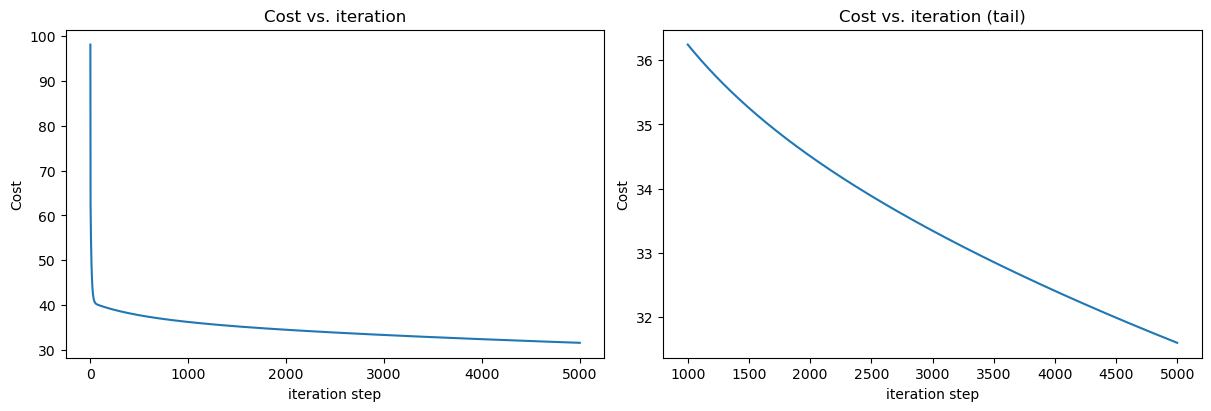

In [30]:
# plot cost versus iteration for the raw data
fig, (ax1, ax2) = plt.subplots(1, 2, constrained_layout=True, figsize=(12, 4))
ax1.plot(J_hist)
ax2.plot(1000 + np.arange(len(J_hist[1000:])), J_hist[1000:])
ax1.set_title("Cost vs. iteration");  ax2.set_title("Cost vs. iteration (tail)")
ax1.set_ylabel('Cost')             ;  ax2.set_ylabel('Cost') 
ax1.set_xlabel('iteration step')   ;  ax2.set_xlabel('iteration step') 
plt.show()

In [31]:
#
# Then, the normalized data 
# (note: a faster learning rate works well and fewer iterations are needed)
#

# some gradient descent settings
iterations = 2000
alpha = 5.0e-2
# run gradient descent
w_final_norm, b_final_norm, J_hist_norm = gradient_descent(X_norm, y_train, initial_w,
                                                           initial_b, compute_cost,
                                                           compute_gradient,
                                                           alpha, iterations)
print(f"b,w found by gradient descent with normalized data: {b_final_norm:0.2f},{w_final_norm} ")

Iteration    0: Cost 261.4829   
Iteration  200: Cost  11.0804   
Iteration  400: Cost  10.9767   
Iteration  600: Cost  10.9554   
Iteration  800: Cost  10.9496   
Iteration 1000: Cost  10.9480   
Iteration 1200: Cost  10.9476   
Iteration 1400: Cost  10.9475   
Iteration 1600: Cost  10.9474   
Iteration 1800: Cost  10.9474   
b,w found by gradient descent with normalized data: 22.53,[-0.92787784  1.08109631  0.13943449  0.68194939 -2.0564635   2.67449615
  0.01924104 -3.10415101  2.65852005 -2.07257783 -2.06047006  0.84924237
 -3.74348452] 


### Implementing the Algorithm on the Normalized Data

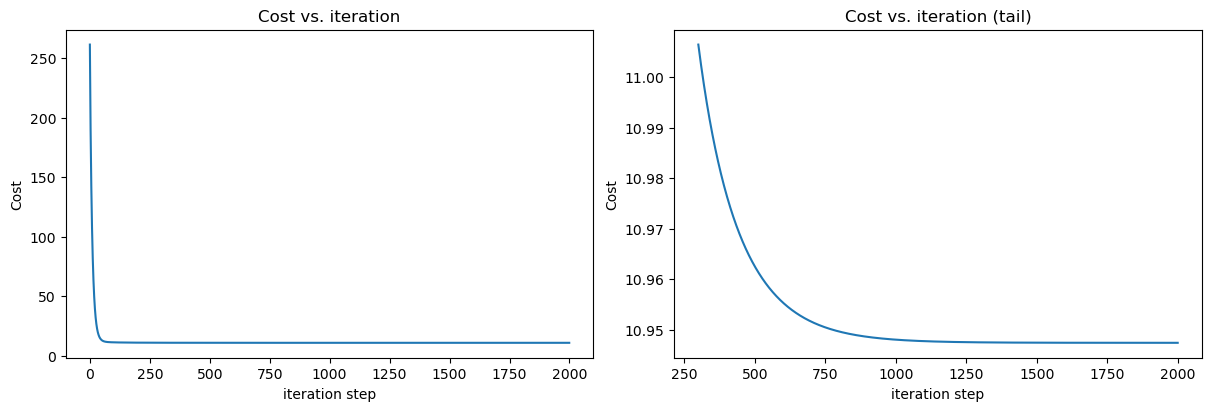

In [19]:
# plot cost versus iteration for the normalized data
fig, (ax1, ax2) = plt.subplots(1, 2, constrained_layout=True, figsize=(12, 4))
ax1.plot(J_hist_norm)
ax2.plot(300 + np.arange(len(J_hist_norm[300:])), J_hist_norm[300:])
ax1.set_title("Cost vs. iteration");  ax2.set_title("Cost vs. iteration (tail)")
ax1.set_ylabel('Cost')             ;  ax2.set_ylabel('Cost') 
ax1.set_xlabel('iteration step')   ;  ax2.set_xlabel('iteration step') 
plt.show()

As advertised, it looks like normalizing the feature values does improve the efficiency of the gradient descent.

We can also plot the predictions from the normalized model agains the target values:

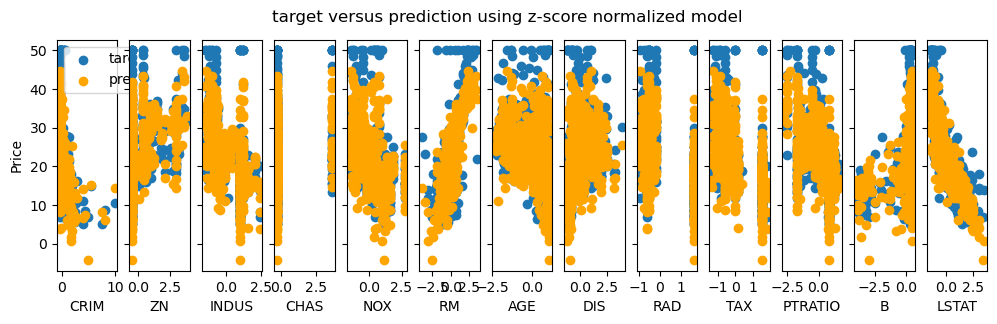

In [25]:
#predict target using normalized features
m = X_norm.shape[0]
yp = np.zeros(m)
for i in range(m):
    yp[i] = np.dot(X_norm[i], w_final_norm) + b_final_norm

    # plot predictions and targets versus original features    
fig,ax=plt.subplots(1,13,figsize=(12, 3),sharey=True)
for i in range(len(ax)):
    ax[i].scatter(X_norm[:,i],y_train, label = 'target')
    ax[i].set_xlabel(feature_names[i])
    ax[i].scatter(X_norm[:,i],yp, color="orange", label = 'predict')
ax[0].set_ylabel("Price"); ax[0].legend();
fig.suptitle("target versus prediction using z-score normalized model")
plt.show()

Not too bad!